# Exploration of representation drift through reduced model

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from disp import set_font_size, set_color


# PARAMS
N = 1000
M = 200
N_MAX = 200
Q = .1
THT_S = 1
W_MIN = THT_S/50 + .0001
W_MAX = THT_S/4 + .0001

T_THT = 4
A_THT = 1

I_STD_0 = .375  # BASELINE NOISE
I_STD_1 = .8  # REACTIVATION NOISE

Run smln

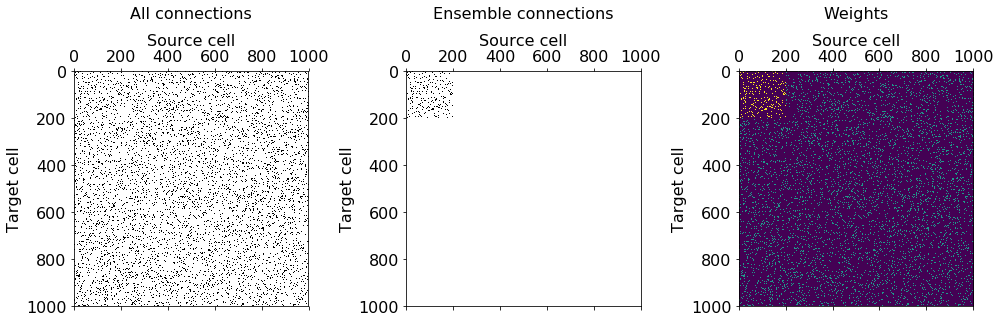

In [2]:
np.random.seed(0)

# set up weights
cxn = np.random.rand(N, N) < Q
w = np.zeros((N, N))
w[cxn] = W_MIN

# set up strongly connected ensemble
ens_mask = np.zeros(N, dtype=bool)
ens_mask[:M] = True
ens_cxn = cxn & np.outer(ens_mask, ens_mask)
w[ens_cxn] = W_MAX

# plot cxn matrices and weight matrices
fig, axs = plt.subplots(1, 3, figsize=(14, 5), tight_layout=True)
axs[0].spy(cxn)
axs[0].set_title('All connections\n\n')
axs[1].spy(ens_cxn)
axs[1].set_title('Ensemble connections\n\n')
axs[2].matshow(w, vmin=0, vmax=.15*W_MAX)
axs[2].set_title('Weights\n\n')

for ax in axs:
    ax.set_xlabel('Source cell')
    ax.set_ylabel('Target cell')
    ax.xaxis.set_label_position('top')
    set_font_size(ax, 16)

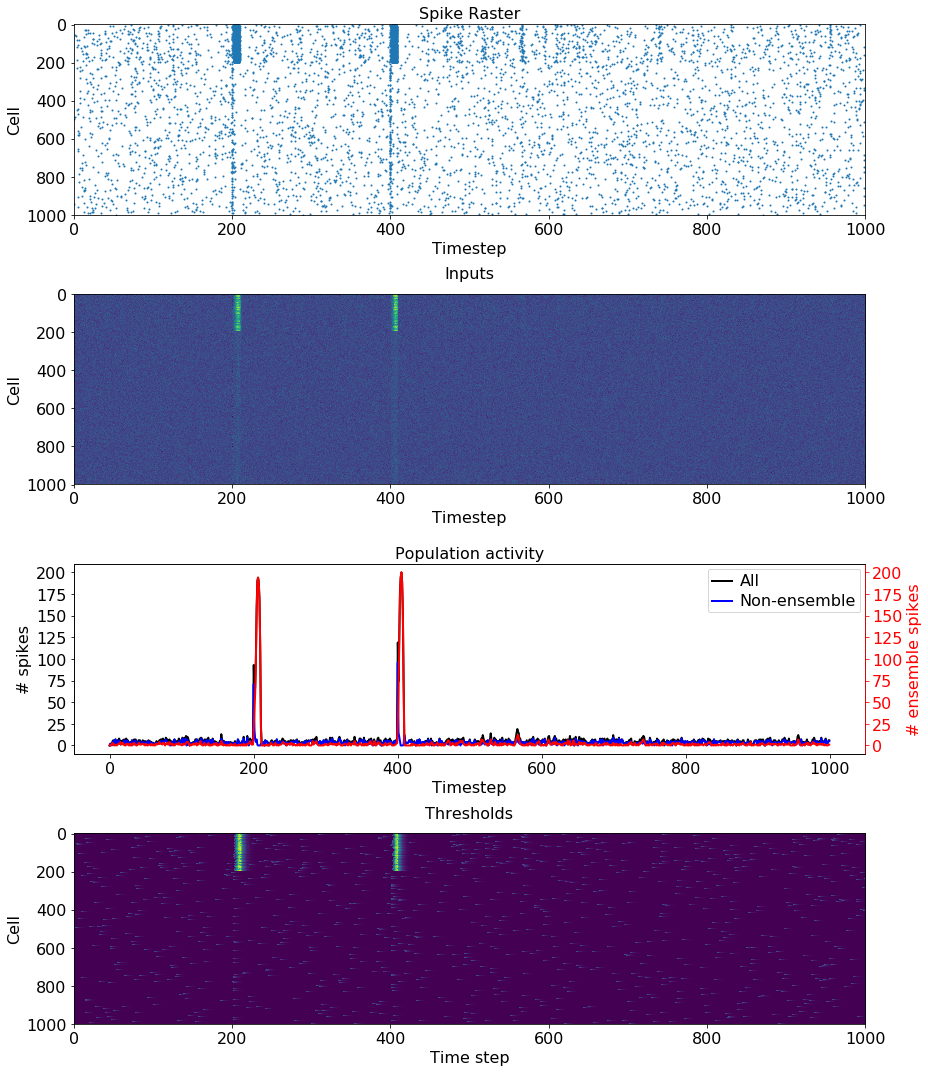

In [3]:
# run
np.random.seed(0)
N_T = 1000
T_REACT = [200, 400]

vs = np.zeros((N_T, N))
thts = THT_S * np.ones((N_T, N))
spks = np.zeros((N_T, N), dtype=bool)

for t in range(1, N_T):
    # get inputs
    ## external
    if t in T_REACT:
        i_ext = I_STD_1 * np.random.randn(N)
    else:
        i_ext = I_STD_0 * np.random.randn(N)
        
    ## recurrent
    i_rcr = w.dot(spks[t-1, :])
    
    ## total
    v = i_ext + i_rcr
    
    # thresholds
    tht = thts[t-1, :] - (1/T_THT)*(thts[t-1, :] - THT_S) + A_THT*spks[t-1, :]
    
    # mask N_MAX highest vs
    v_max = np.zeros(N, dtype=bool)
    v_max[np.argsort(v)[-N_MAX:]] = True
    
    # get spks
    spk = (v >= tht) & v_max  # spk if v above threshold and included in max vs
    
    vs[t, :] = v.copy()
    thts[t, :] = tht.copy()
    spks[t, :] = spk.copy()
    
t = np.arange(N_T)

# plot
fig, axs = plt.subplots(4, 1, figsize=(13, 15), tight_layout=True)

## raster
axs[0].scatter(*np.nonzero(spks), s=1)
axs[0].set_xlim(0, N_T)
axs[0].set_ylim(N, -1)
axs[0].set_xlabel('Timestep')
axs[0].set_ylabel('Cell')
axs[0].set_title('Spike Raster')

## inputs
axs[1].matshow(vs.T, origin='upper', aspect='auto')
axs[1].xaxis.tick_bottom()
axs[1].set_xlim(0, N_T)
axs[0].set_ylim(N, -1)
axs[1].set_xlabel('Timestep')
axs[1].set_ylabel('Cell')
axs[1].set_title('Inputs')

## population activity
axs[2].plot(t, spks.sum(1), lw=2, color='k')
axs[2].plot(t, spks[:, ~ens_mask].sum(1), lw=2, color='b')
axs[2].set_xlim(0, N_T)
axs[2].set_xlabel('Timestep')
axs[2].set_ylabel('# spikes')
axs[2].legend(['All', 'Non-ensemble'])
axs[2].set_title('Population activity')

ax_twin = axs[2].twinx()
ax_twin.plot(t, spks[:, ens_mask].sum(1), lw=2, color='r')
ax_twin.set_ylabel('# ensemble spikes')

set_color(ax_twin, 'r')

axs[3].matshow(thts.T, origin='upper', aspect='auto')
axs[3].xaxis.tick_bottom()
axs[3].set_xlim(0, N_T)
axs[0].set_ylim(N, -1)
axs[3].set_xlabel('Time step')
axs[3].set_ylabel('Cell')
axs[3].set_title('Thresholds')

for ax in list(axs) + [ax_twin]:
    set_font_size(ax, 16)